In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.individual.hooks as hooks
from multitask.models.individual import get_individual_model, calculate_rdm, plot_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figureS07a_rdm_individual.svg')
path_model_individual = os.path.join('..', '..', 'results', 'individual')
path_pickle = os.path.join('pickle', 'rdm_individual.pickle')

## RDM Individual

In [4]:
num_runs = 10
initial_seed = 1234
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 41080
num_test = 8216
tasks_names = ['vowel', 'position']

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': None
}

data_folder = check_runs(path_model_individual, parameters)

Found simulation in ../../results/individual with the same parameters (2024-01-12_16-59-07)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_individual = pickle.load(handle)

In [7]:
seeds = sorted(list(results_individual.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[165158, 220532, 318129, 451283, 486191, 514041, 818831, 869016, 908341, 978124]
['vowel', 'position']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

## Plot All RDMs

In [9]:
tasks_datasets

{'vowel': Dataset VowelTask
     Number of datapoints: 49296
     Root location: ../../data
     Split: Train,
 'position': Dataset PositionTask
     Number of datapoints: 49296
     Root location: ../../data
     Split: Train}

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

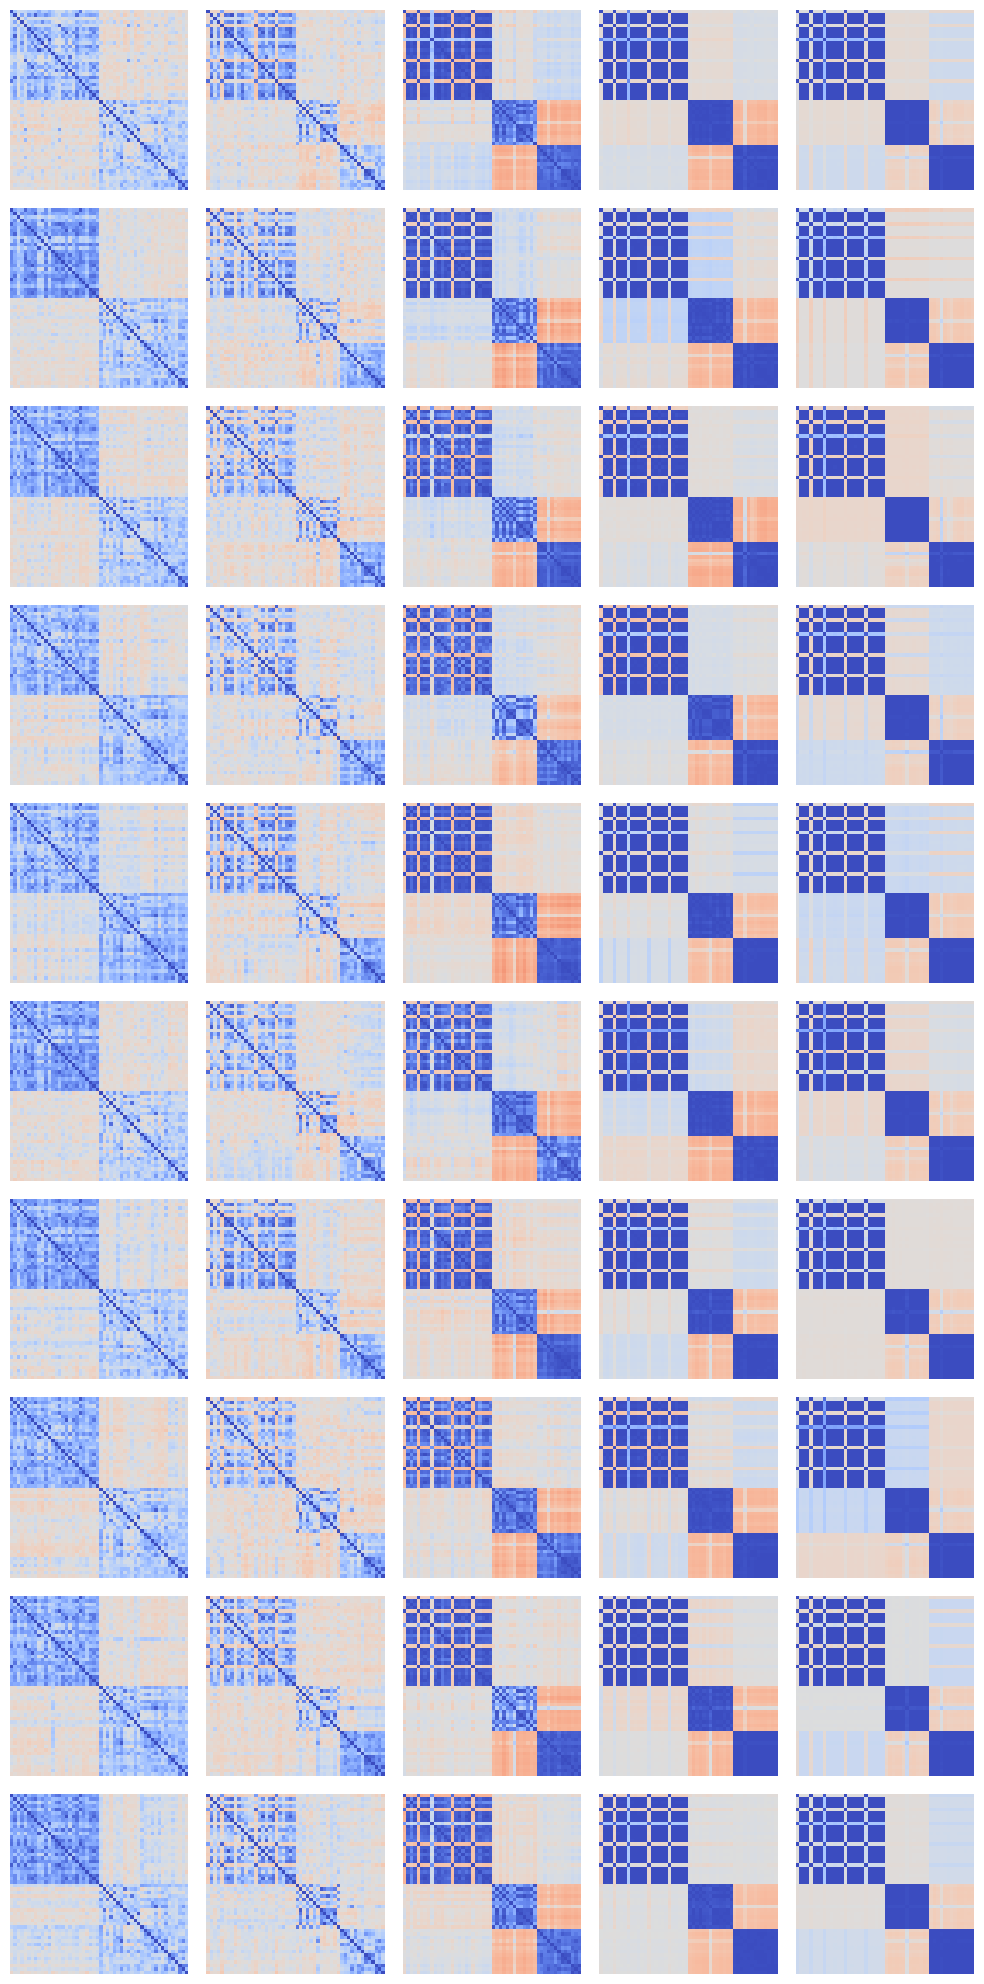

In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

fig, ax = plt.subplots(num_seeds, num_layers, figsize=(2 * num_layers, 2 * num_runs))
list_rdm = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_seeds):
    task_activations = []
    task_letters = []
    indices = results_individual[seed]['indices']

    for i_task, task_name in enumerate(tasks_names):
        state_dict = results_individual[seed][task_name]['model']

        model = get_individual_model(num_hidden,
                                     device)
        model.load_state_dict(state_dict)
        model.to(device)

        task_dataset = tasks_datasets[task_name]
        test_sampler = dataset.SequentialSampler(indices['test'])
        testloader = torch.utils.data.DataLoader(task_dataset,
                                                 sampler=test_sampler,
                                                 batch_size=batch_size)

        letters = testloader.dataset.letters.numpy()
        letters = letters[indices['test']]

        _, activations = hooks.get_layer_activations(model,
                                                     testloader,
                                                     criterion,
                                                     device=device,
                                                     disable=True)
        
        task_activations.append(activations)
        task_letters.append(letters)

    rdm_dict = calculate_rdm(task_activations,
                             tasks_names,
                             num_hidden,
                             task_letters)

    plot_rdm(ax[i_seed], rdm_dict, num_hidden, cmap='coolwarm', vmin=0, vmax=1)

    list_rdm.append(rdm_dict)

fig.tight_layout()
plt.show()

In [11]:
parent_pickle = os.path.dirname(path_pickle)

if not os.path.exists(parent_pickle):
    os.makedirs(parent_pickle)

with open(path_pickle, 'wb') as f:
    pickle.dump(list_rdm, f, protocol=pickle.HIGHEST_PROTOCOL)

## Average RDM

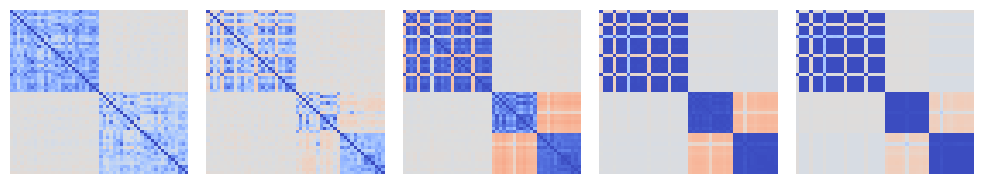

In [12]:
mean_rdm = {}

for layer in range(num_layers):
    mean_rdm[layer+1] = np.zeros_like(list_rdm[0][layer+1])
    for rdm in list_rdm:
        mean_rdm[layer+1] += rdm[layer+1]
    mean_rdm[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
fig.tight_layout()
fig.savefig(path_figure)
plt.show()

## Plot Single RDM

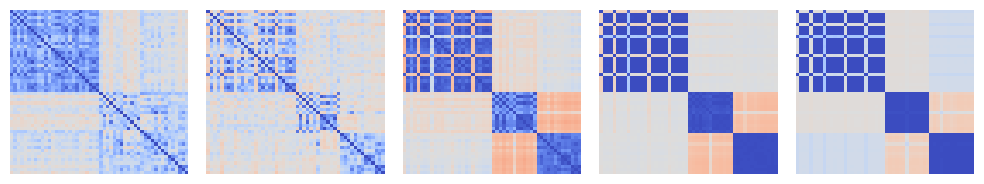

In [13]:
idx_seed = 0
seed = seeds[idx_seed]

state_dict = results_individual[seed][task_name]['model']
indices = results_individual[seed]['indices']

model = get_individual_model(num_hidden, device)
model.load_state_dict(state_dict)

task_dataset = tasks_datasets[task_name]
test_sampler = dataset.SequentialSampler(indices['test'])
testloader = torch.utils.data.DataLoader(task_dataset,
                                            sampler=test_sampler,
                                            batch_size=batch_size)

letters = testloader.dataset.letters.numpy()
letters = letters[indices['test']]

_, activations = hooks.get_layer_activations(model,
                                             testloader,
                                             criterion,
                                             device=device,
                                             disable=True)

task_activations.append(activations)
task_letters.append(letters)

rdm_dict = calculate_rdm(task_activations,
                        tasks_names,
                        num_hidden,
                        task_letters)

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, rdm_dict, num_hidden, cmap='coolwarm', vmin=0, vmax=1)

fig.tight_layout()
plt.show()